# Quickstart Example of Off-Policy Evaluation of Online Bandit Algorithms
---
This notebook provides an example of conducting OPE of online bandit algorithms using Replay Method (RM) with synthetic bandit feedback data.
RM uses a subset of the logged bandit feedback data where actions selected by the behavior policy are the same as that of the evaluation policy.
Theoretically, RM is unbiased when the behavior policy is uniformly random and the evaluation policy is fixed.
However, empirically, RM works well when evaluation policies are learning algorithms.
Please refer to https://arxiv.org/abs/1003.5956 about the details of RM.

Our example with online bandit algorithms contains the follwoing three major steps:
- (1) Synthetic Data Generation
- (2) Off-Policy Evaluation (OPE)
- (3) Evaluation of OPE

Please see [../examples/online](../online) for a more sophisticated example of the evaluation of OPE of online bandit algorithms.

In [1]:
import numpy as np
# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function
)
from obp.policy import EpsilonGreedy, LinTS, LinUCB
from obp.ope import (
    OffPolicyEvaluation, 
    ReplayMethod
)
from obp.simulator import run_bandit_simulation

In [2]:
# obp version
print(obp.__version__)

0.3.3


## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: `SyntheticBanditDataset` class in the dataset module.

It takes number of actions (`n_actions`), dimension of context vectors (`dim_context`), reward function (`reward_function`), and behavior policy (`behavior_policy_function`) as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [3]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function
# we use the uniformly random behavior policy because it is desriable for RM
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=None, # uniformly random
    random_state=12345,
)
# obtain a set of synthetic logged bandit feedback
n_rounds = 100000
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback

{'n_rounds': 100000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [ 1.36946256,  0.58727761, -0.69296769, -0.27519988, -2.10289159],
        [-0.27428715,  0.52635353,  1.02572168, -0.18486381,  0.72464834],
        [-1.25579833, -1.42455203, -0.26361242,  0.27928604,  1.21015571]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([8, 4, 0, ..., 8, 9, 7]),
 'position': array([0,

## (2) Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of online bandit algorithms using the logged bandit feedback and RM.

Here, we visualize the OPE results.

In [4]:
# simulations of online bandit algorithms
# obtain a deterministic action distribution representing which action is selected at each round in the simulation
# policies are updated only when the selected action is the same as that of the logged data
evaluation_policy_a = EpsilonGreedy(
    n_actions=dataset.n_actions,
    epsilon=0.1,
    random_state=12345
)
action_dist_a = run_bandit_simulation(bandit_feedback, evaluation_policy_a)

evaluation_policy_b = LinTS(
    dim=dataset.dim_context,
    n_actions=dataset.n_actions,
    random_state=12345
)
action_dist_b = run_bandit_simulation(bandit_feedback, evaluation_policy_b)

evaluation_policy_c = LinUCB(
    dim=dataset.dim_context,
    n_actions=dataset.n_actions,
    random_state=12345
)
action_dist_c = run_bandit_simulation(bandit_feedback, evaluation_policy_c)

100%|██████████| 100000/100000 [00:14<00:00, 6756.46it/s]


In [5]:
# estimate the policy value of the online bandit algorithms using RM
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[ReplayMethod()]
)

`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.
`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.
`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.


    95.0% CI (lower)  95.0% CI (upper)      mean
rm          0.601383          0.629415  0.615252 



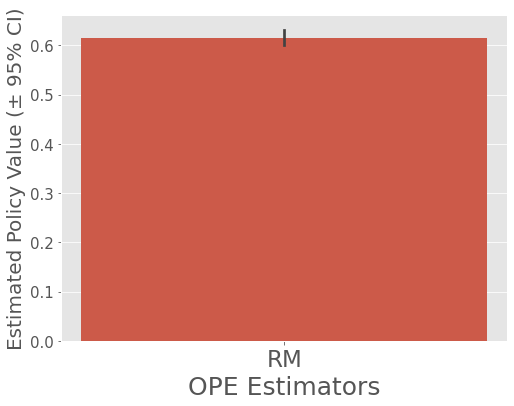

In [6]:
# estimate the policy value of EpsilonGreedy
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist_a
)
print(estimated_interval_a, '\n')

# visualize estimated policy values of EpsilonGreedy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_a,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.
`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.
`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.


    95.0% CI (lower)  95.0% CI (upper)      mean
rm          0.697539          0.725701  0.710688 



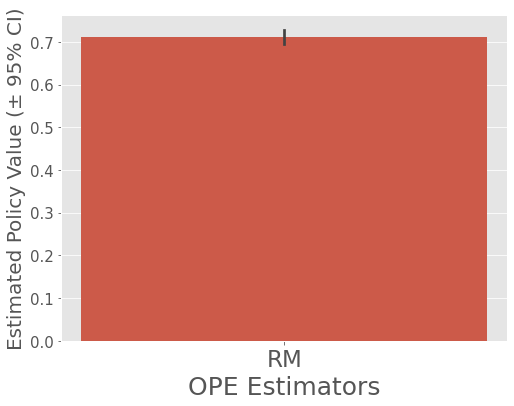

In [7]:
# estimate the policy value of LinTS
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    action_dist=action_dist_b
)
print(estimated_interval_b, '\n')

# visualize estimated policy values of LinTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_b,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.
`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.
`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.


    95.0% CI (lower)  95.0% CI (upper)      mean
rm          0.666875            0.6981  0.682404 



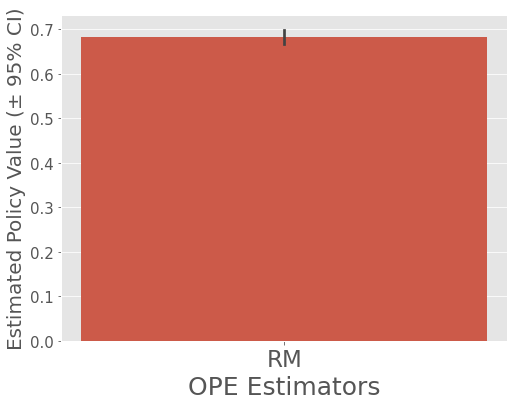

In [8]:
# estimate the policy value of LinUCB
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_dist=action_dist_c
)
print(estimated_interval_c, '\n')

# visualize estimated policy values of LinUCB by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_c,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

RM estimates that LinTS is the best policy.

## (3) Evaluation of OPE
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by RM with the ground-turths to evaluate the accuracy of OPE.

In [9]:
# we first calculate the policy values of the three evaluation policies using the expected rewards of the test data
expected_rewards = bandit_feedback['expected_reward']
policy_value_a = np.average(expected_rewards, weights=action_dist_a[:, :, 0], axis=1).mean()
policy_value_b = np.average(expected_rewards, weights=action_dist_b[:, :, 0], axis=1).mean()
policy_value_c = np.average(expected_rewards, weights=action_dist_c[:, :, 0], axis=1).mean()

print(f'policy value of EpsilonGreedy: {policy_value_a}')
print(f'policy value of LinTS: {policy_value_b}')
print(f'policy value of LinUCB: {policy_value_c}')

policy value of EpsilonGreedy: 0.6104368686610999
policy value of LinTS: 0.7182133343802966
policy value of LinUCB: 0.681387402045725


In fact, LinTS reveals the best performance among the three evaluation policies.

Using the above policy values, we evaluate the estimation accuracy of the OPE estimators.

In [10]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of EpsilonGreedy and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_a = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_a,
    action_dist=action_dist_a,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_a

`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.


,relative-ee
rm,0.008859


In [11]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of LinTS t and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_b = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_b,
    action_dist=action_dist_b,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_b

`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.


,relative-ee
rm,0.009187


In [12]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of LinUCB and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_c = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_c,
    action_dist=action_dist_c,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_c

`estimated_rewards_by_reg_model` is not given; model dependent estimators such as DM or DR cannot be used.


,relative-ee
rm,0.001211


Please see [../examples/online](../online) for a more sophisticated example of the evaluation of OPE with online bandit algorithms.